# Tabular data augmentation with score-based generative models 

The selected dataset is the [Default Payments of Credit Card Clients](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset) which contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. This dataset is usually used in classification models in order to build payment default scoring models. 

However, the imbalanced class issue can make it difficult to build a scorer which correctly detects default payments. One solution to this problem is to synthetically generate data to increase the number of default payments. For this purpose we use **score-based generative modeling with multiple noise perturbations**. The main idea is to represent a distribution by modeling its score function, which can be estimated by training a score-based model of free-form architectures with score matching.

It consists in two steps: 

1. Learn score functions using **gradients of log probability density functions** on a large number of noise-perturbed data distributions
2. Generate samples with **Langevin-type sampling**

## ToDo

- Use other NN architectures (CNN) 
- Test VAE using `dta` library
- Methods to assess synthetic data quality

## Setup

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
import gc 

gc.collect()

0

In [312]:
import pandas as pd
import numpy as np 

from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression

import sdv.evaluation.single_table as sdv_eval
from sdv.single_table import (
    GaussianCopulaSynthesizer,
    CTGANSynthesizer, 
    TVAESynthesizer
)

In [267]:
pd.set_option("display.max_columns", None)

In [268]:
from src.utils import (
    load_config, 
    load_pickle, 
    get_clf_metrics, 
    display_clf_metrics, 
    make_sdv_metadata
)
from src.data import Data
from src.runner.scorenet_runner import ScoreNetRunner
from src.runner.anneal_runner import AnnealRunner

## Load original data

In [269]:
df = pd.read_csv("datasets/taiwan_payment.csv")

df.columns = df.columns.map(lambda col: col.replace(".", "_").lower())
df.drop(columns=["id"], inplace=True)

df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [270]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_bal                   30000 non-null  float64
 1   sex                         30000 non-null  int64  
 2   education                   30000 non-null  int64  
 3   marriage                    30000 non-null  int64  
 4   age                         30000 non-null  int64  
 5   pay_0                       30000 non-null  int64  
 6   pay_2                       30000 non-null  int64  
 7   pay_3                       30000 non-null  int64  
 8   pay_4                       30000 non-null  int64  
 9   pay_5                       30000 non-null  int64  
 10  pay_6                       30000 non-null  int64  
 11  bill_amt1                   30000 non-null  float64
 12  bill_amt2                   30000 non-null  float64
 13  bill_amt3                   300

In [271]:
df["default_payment_next_month"].value_counts(normalize=True, dropna=False)

0    0.7788
1    0.2212
Name: default_payment_next_month, dtype: float64

In [272]:
df_default = df[df["default_payment_next_month"] == 1]
df_default.drop(columns=["default_payment_next_month"], inplace=True)

Entries which have defaulted on their credit only account for 22% of the entire dataset. We thus focus the generative process on these samples. 

## Data preparation

In [378]:
CFG_TYPE = "scorenet"                           # "scorenet" or "anneal"
cfg = load_config(f"configs/{CFG_TYPE}.yaml") 

In [379]:
data = Data(cfg["data"])

data.preprocess(df)
data.make_loaders()

print(data) 

Data(target=default_payment_next_month, classification=True, reference=1, test_prop=0.2, batch_size=64, n_batches=375)


## Train generator

The loss function used to train the score-based generator depends on the `algo` argument entered in [`config`](configs/): 

- `dsm` means we use the denoising score matching objective as loss function
- `ssm` means we use sliced score matching objective to greatly scale up the computation of score matching. 

One can also choose to add multiple noise perturbations with the [`anneal`](configs/anneal.yaml) configuration.

More details can be found [here](https://yang-song.net/blog/2019/ssm/). 

In [380]:
if CFG_TYPE == "scorenet":
    runner = ScoreNetRunner(cfg, data)

elif CFG_TYPE == "anneal":
    runner = AnnealRunner(cfg, data) 

if cfg["mode"] == "train":
    loss_tracker = runner.train()

elif cfg["mode"] == "eval":
    loss_tracker = load_pickle(f"{cfg['backup']['dir']}/loss.pkl")

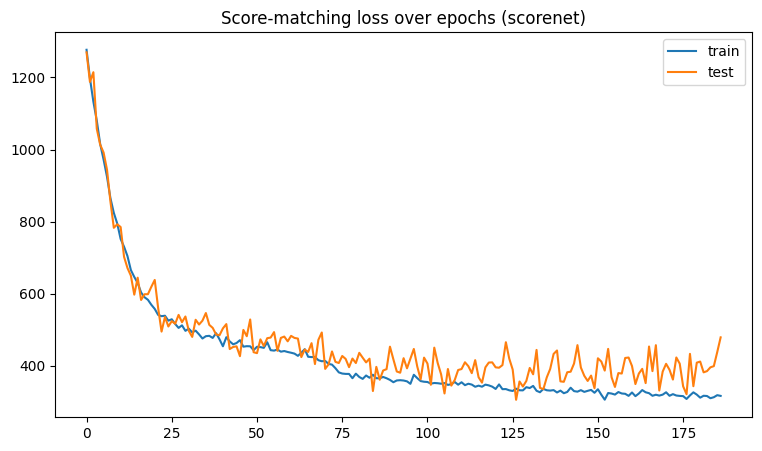

In [381]:
pd.DataFrame(loss_tracker).plot(figsize=(9, 5), title=f"Score-matching loss over epochs ({CFG_TYPE})"); 

## Generate new samples

Once the score-based model trained, we can use an iterative procedure called Langevin dynamics to draw samples from it. Langevin dynamics provides an MCMC procedure to sample from a distribution using only its score function.

In [382]:
synthetic_samples = runner.sample(n_batches=100)
synthetic_samples.shape

Generating 100 batches with 64 samples each using Langevin dynamics.:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([6400, 30])

In [383]:
data.generate(synthetic_samples)

In [256]:
data.synthetic_df.head()

,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,sex,education,marriage
0,-6581738.00,-572.757874,0.478154,125.135750,182.971130,67.081230,-84.145615,-2.535984,13823098.00,1614735.0,-4.760313e+04,-3.543278e+06,-4.081441e+05,1639361.75,-1.627995e+06,-2.306457e+06,1.067700e+06,1.188492e+06,-9.233039e+05,2674111.50,2.0,3.0,3.0
1,-3750862.25,1225.976562,-31.794752,60.322010,312.942261,84.981033,-240.056656,-110.099815,-4100705.00,11838650.0,1.055514e+06,-3.514893e+06,-1.504539e+06,-3585128.50,-8.686194e+04,-2.859341e+06,1.745990e+06,-1.687505e+05,-1.469779e+06,2488384.50,2.0,4.0,1.0
2,-4204146.00,-198.035568,167.207825,7.751224,260.450195,-39.795845,-267.621887,89.090790,7960726.00,14583100.0,4.004070e+06,-2.588000e+05,3.130032e+06,8023536.00,4.621853e+05,-2.858948e+04,-1.715928e+05,4.296018e+05,-4.983177e+05,2966503.50,2.0,4.0,3.0
3,-1666638.75,1603.976685,79.246155,118.909561,88.346016,113.287643,-135.802170,-43.118374,-2914941.75,16409981.0,-9.837735e+04,6.036682e+06,-1.336862e+06,4323587.00,-6.050822e+05,-2.930798e+06,-3.730612e+06,1.600188e+06,-4.110007e+05,5216235.00,2.0,4.0,3.0
4,-4027800.25,-197.731735,256.036682,29.838396,148.314041,166.187363,-169.053711,-104.455315,4084539.50,8223115.5,-5.046576e+06,-1.426519e+06,-1.053248e+06,2593524.75,-1.202467e+06,-1.020676e+06,-1.034135e+06,3.124198e+06,-4.064802e+05,2392879.75,2.0,4.0,3.0


## Evaluate synthetic data quality

The quality score is the average between two general scores which are `Column Pair Trends` and `Column Shapes`. 

**`Column Pair Trends`**

It is the average between `ContingencySimilarity` and `CorrelationSimilarity` scores. 

For categorical variables, the score is `ContingencySimilarity` which computes the similarity of a pair of categorical columns between the real and synthetic datasets. For a pair of columns, $A$ and $B$, the test computes a normalized contingency table for the real and synthetic data. This table describes the proportion of rows that have each combination of categories in $A$ and $B$.
Then, it computes the difference between the contingency tables using the Total Variation Distance. Finally, we subtract the distance from 1 to ensure that a high score means high similarity. 

$$
s_{con} = 1 - \frac{1}{2} \sum_{\alpha \in A} \sum_{\beta \in B} |S_{\alpha, \beta} - R_{\alpha, \beta}|
$$

where $\alpha$ describes all the possible categories in column $A$ and $\beta$ describes all the possible categories in column $B$. $R$ and $S$ refer to the real and synthetic frequencies for those categories.

If the contingency table is exactly the same between the real vs. synthetic data, then $s_{cor}=1$. The more different the contingency tables, the closer $s_{con}$ to 0. 

For numerical variables, the score is `CorrelationSimilarity` measures the correlation between a pair of numerical columns and computes the similarity between the real and synthetic data. This metric supports both the Pearson and Spearman's rank coefficients to measure correlation. For a pair of columns, $A$ and $B$, this test computes a correlation coefficient on the real and synthetic data, $R$ and $S$. This yields two separate correlation values. The test normalizes and returns a similarity score using the formula below.

$$
s_{cor} = 1 - \frac{1}{2} |S_{A, B} - R_{A, B}|
$$

The pairwise correlations of the real and synthetic data are exactly the same if $s_{cor} = 1$. The more different the pairwise correlations, the closer $s_{cor}$ to 0. 

**`Column Shapes`**

This score is computed as the average between the `KSComplement` and `TVComplement` scores which computes the similarity of a real column vs. a synthetic column in terms of the column shapes (marginal distributions). 

The `KSComplement` score uses the Kolmogorov-Smirnov statistic to compare the distributions of the two continuous columns using the empirical CDF. It returns 1 minus the KS Test D statistic, which indicates the maximum distance between the expected CDF and the observed CDF values.

`TVComplement` is the Total Variation Distance (TVD) between the real and synthetic columns. It first computes the frequency of each category value and expresses it as a probability. The TVD statistic compares the differences in probabilities, as shown in the formula below.

$$
\delta(R, S) = \frac{1}{2} \sum_{\omega \in \Omega} |R_{\omega} - S_{\omega}|
$$

where $\omega$ describes all the possible categories in a column $\Omega$. The `TVComplement` score is:

$$
s_{TV} = 1 - \delta(R, S)
$$

In [384]:
metadata = make_sdv_metadata(data)

real_data = df_default.copy()
synthetic_data = data.synthetic_df.copy()

In [385]:
quality_report = sdv_eval.evaluate_quality(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]



Overall Quality Score: 51.78%

Properties:
Column Shapes: 38.7%
Column Pair Trends: 64.87%


In [300]:
column = "limit_bal"

fig = sdv_eval.get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name=column,
    metadata=metadata)
        
fig.show()

## Classification models

With a view to assess the quality of the generated samples, we train 2 classifiers. The first one is trained on the original data whereas the second one is trained on the augmented dataset. Note the latter contains more default entries than the former due to data augmentation. 

In [301]:
target_names = ["No Default", "Default"]

clf = LogisticRegression(max_iter=1000)
clf.fit(data.X_tr, data.y_tr)

clf_report = get_clf_metrics(clf, data.X_tr, data.y_tr, data.X_te, data.y_te, target_names)

In [302]:
X_tr_aug = np.concatenate([data.X_tr, data.X_syn])
y_syn = np.ones(data.X_syn.shape[0])
y_tr_aug = np.concatenate([data.y_tr, y_syn])

clf_aug = LogisticRegression(max_iter=1000)
clf_aug.fit(X_tr_aug, y_tr_aug) 

clf_aug_report = get_clf_metrics(clf_aug, X_tr_aug, y_tr_aug, data.X_te, data.y_te, target_names)

In [303]:
display_clf_metrics(clf_report, clf_aug_report)

              Classification Report (train)              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.819         │ 0.816          │
│ No Default recall    │ 0.972         │ 0.964          │
│ No Default f1-score  │ 0.889         │ 0.884          │
│ Default precision    │ 0.716         │ 0.919          │
│ Default recall       │ 0.245         │ 0.655          │
│ Default f1-score     │ 0.365         │ 0.765          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

              Classification Report (test)               
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.82          │ 0.825          │
│ No Default recall    │ 0.971         │ 0.964          │
│ No Default f1-score  │ 0.889         │ 0.889          │
│ Default precision    │ 0.698         │ 0.676          │
│ Default recall       │ 0.24          │ 0.268          │
│ Default f1-score     │ 0.357         │ 0.384          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

## Other generators

### Fit generators

In [313]:
generators = {
    "GaussianCopula": GaussianCopulaSynthesizer(metadata),
    "CTGAN": CTGANSynthesizer(metadata),
    "TVAE": TVAESynthesizer(metadata),
}

In [314]:
loop = tqdm(generators.items(), total=len(generators)) 

for key, generator in loop:
    loop.set_description(f"Fitting {key}...") 
    generator.fit(real_data)
    generators[key] = generator

# for key, generator in generators.items():
#     path = f"backup/taiwan_payment/sdv/{key}.pkl".lower()
#     generator.save(path)

  0%|          | 0/3 [00:00<?, ?it/s]

In [321]:
generator_names = ["GaussianCopula", "CTGAN", "TVAE"]

generators = {
    key: load_pickle(f"backup/taiwan_payment/sdv/{key}.pkl".lower())
    for key in generator_names
}

### Generate synthetic samples

In [322]:
n_samples = 5000

synthetic_datasets = {
    key: generator.sample(n_samples) for key, generator in generators.items()
}

In [339]:
feature_matrix_aug = {}

for key, ds in synthetic_datasets.items():
    x = data._preprocessor.transform(ds)
    feature_matrix_aug[key] = np.concatenate([data.X_tr, x])

target_aug = np.concatenate([data.y_tr, np.ones(n_samples)])

### Evaluate data quality 

In [335]:
quality_reports = {
    key: sdv_eval.evaluate_quality(
        real_data=real_data,
        synthetic_data=ds,
        metadata=metadata) 
    for key, ds in synthetic_datasets.items()
}

Creating report: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]



Overall Quality Score: 84.66%

Properties:
Column Shapes: 77.9%
Column Pair Trends: 91.43%


Creating report: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]



Overall Quality Score: 90.22%

Properties:
Column Shapes: 88.11%
Column Pair Trends: 92.34%


Creating report: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]



Overall Quality Score: 89.51%

Properties:
Column Shapes: 89.46%
Column Pair Trends: 89.56%


### Augmented classification models

In [340]:
clf_sdv = {
    key: LogisticRegression(max_iter=1000).fit(X_aug, target_aug) 
    for key, X_aug in feature_matrix_aug.items()
}

In [341]:
clf_sdv_report = {
    key: get_clf_metrics(clf, feature_matrix_aug[key], target_aug, data.X_te, data.y_te, target_names)
    for key, clf in clf_sdv.items()
}

In [362]:
for key, report in clf_sdv_report.items():
    title = f"Classification report for {key}"
    display_clf_metrics(clf_report, report, title=title)
    print("-"*70)

display_clf_metrics(clf_report, clf_aug_report, title=f"Classification report for {CFG_TYPE}")

    Classification report for GaussianCopula (train)     
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.819         │ 0.821          │
│ No Default recall    │ 0.972         │ 0.932          │
│ No Default f1-score  │ 0.889         │ 0.873          │
│ Default precision    │ 0.716         │ 0.836          │
│ Default recall       │ 0.245         │ 0.632          │
│ Default f1-score     │ 0.365         │ 0.72           │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

     Classification report for GaussianCopula (test)     
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.82          │ 0.823          │
│ No Default recall    │ 0.971         │ 0.931          │
│ No Default f1-score  │ 0.889         │ 0.873          │
│ Default precision    │ 0.698         │ 0.535          │
│ Default recall       │ 0.24          │ 0.285          │
│ Default f1-score     │ 0.357         │ 0.372          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

----------------------------------------------------------------------


         Classification report for CTGAN (train)         
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.819         │ 0.776          │
│ No Default recall    │ 0.972         │ 0.922          │
│ No Default f1-score  │ 0.889         │ 0.843          │
│ Default precision    │ 0.716         │ 0.786          │
│ Default recall       │ 0.245         │ 0.519          │
│ Default f1-score     │ 0.365         │ 0.625          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

         Classification report for CTGAN (test)          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.82          │ 0.843          │
│ No Default recall    │ 0.971         │ 0.922          │
│ No Default f1-score  │ 0.889         │ 0.881          │
│ Default precision    │ 0.698         │ 0.581          │
│ Default recall       │ 0.24          │ 0.388          │
│ Default f1-score     │ 0.357         │ 0.465          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

----------------------------------------------------------------------


         Classification report for TVAE (train)          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.819         │ 0.755          │
│ No Default recall    │ 0.972         │ 0.901          │
│ No Default f1-score  │ 0.889         │ 0.822          │
│ Default precision    │ 0.716         │ 0.724          │
│ Default recall       │ 0.245         │ 0.471          │
│ Default f1-score     │ 0.365         │ 0.571          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

          Classification report for TVAE (test)          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.82          │ 0.842          │
│ No Default recall    │ 0.971         │ 0.901          │
│ No Default f1-score  │ 0.889         │ 0.87           │
│ Default precision    │ 0.698         │ 0.528          │
│ Default recall       │ 0.24          │ 0.396          │
│ Default f1-score     │ 0.357         │ 0.453          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

----------------------------------------------------------------------


       Classification report for scorenet (train)        
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.819         │ 0.816          │
│ No Default recall    │ 0.972         │ 0.964          │
│ No Default f1-score  │ 0.889         │ 0.884          │
│ Default precision    │ 0.716         │ 0.919          │
│ Default recall       │ 0.245         │ 0.655          │
│ Default f1-score     │ 0.365         │ 0.765          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

        Classification report for scorenet (test)        
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.82          │ 0.825          │
│ No Default recall    │ 0.971         │ 0.964          │
│ No Default f1-score  │ 0.889         │ 0.889          │
│ Default precision    │ 0.698         │ 0.676          │
│ Default recall       │ 0.24          │ 0.268          │
│ Default f1-score     │ 0.357         │ 0.384          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘